In [1]:
import pandas as pd
import numpy as np

import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import statsmodels.formula.api as smf
import scipy.stats as stats
import factor_analyzer
from plotly.subplots import make_subplots

In [3]:
df_final= pd.read_csv(r"../dados/microdados_enem_2019/dados_enem_processados_v2.csv.zip")
df_final.head()

,NU_INSCRICAO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,N_PESSOAS_MESMA_RED,INTERNET,MEDIA_CANDIDATO,SCORE_CONSUMO,SCORE_CULT_PAIS,RENDA
0,190001867757,2,1,1,1,1,2,0,3,1.0,0,4.0,1.0,1.0,2,1,722.58,18,8.0,2245
1,190001692704,3,1,1,1,1,2,0,2,1.0,1,2.0,1.0,1.0,3,0,477.44,13,4.0,0
2,190001595660,2,1,1,2,1,2,0,2,1.0,2,2.0,1.0,1.0,3,1,498.76,7,11.0,499
3,190001421552,2,0,1,2,1,2,0,2,1.0,3,2.0,1.0,1.0,2,1,614.34,7,5.0,499
4,190001480443,3,0,2,3,4,2,0,2,1.0,4,2.0,1.0,1.0,4,1,422.28,11,6.0,1247


In [4]:
df_final.set_index('NU_INSCRICAO', inplace=True)
df_final.head()

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,N_PESSOAS_MESMA_RED,INTERNET,MEDIA_CANDIDATO,SCORE_CONSUMO,SCORE_CULT_PAIS,RENDA
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,
190001867757,2,1,1,1,1,2,0,3,1.0,0,4.0,1.0,1.0,2,1,722.58,18,8.0,2245
190001692704,3,1,1,1,1,2,0,2,1.0,1,2.0,1.0,1.0,3,0,477.44,13,4.0,0
190001595660,2,1,1,2,1,2,0,2,1.0,2,2.0,1.0,1.0,3,1,498.76,7,11.0,499
190001421552,2,0,1,2,1,2,0,2,1.0,3,2.0,1.0,1.0,2,1,614.34,7,5.0,499
190001480443,3,0,2,3,4,2,0,2,1.0,4,2.0,1.0,1.0,4,1,422.28,11,6.0,1247


In [6]:
df_final.columns

Index(['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA',
       'TP_ENSINO', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
       'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'N_PESSOAS_MESMA_RED',
       'INTERNET', 'MEDIA_CANDIDATO', 'SCORE_CONSUMO', 'SCORE_CULT_PAIS',
       'RENDA'],
      dtype='object')

In [7]:
df_final[['MEDIA_CANDIDATO', 'SCORE_CONSUMO']].describe()

,MEDIA_CANDIDATO,SCORE_CONSUMO
count,880332.000000,880332.000000
mean,529.750393,15.257395
std,80.889918,9.210819
min,96.000000,0.000000
25%,469.260000,8.000000
50%,520.740000,14.000000
75%,583.600000,20.000000
max,850.820000,79.000000


Vamos tomar 3k candidatos desses 800k para visualizações; veja que é um sample representativo da amostra se for tomado aleatoriamente -- que é como pretendemos fazer.

In [8]:
sample=df_final.sample(n=3000, random_state=69)

Esta célula abaixo foi adicionada meramente por desencargo de consciência do autor: 

In [9]:

colunas = ['MEDIA_CANDIDATO', 'SCORE_CONSUMO']
confianca = 0.99

for col in colunas:
    dados_col = sample[col].dropna()
    n = len(dados_col)
    media = np.mean(dados_col)
    intervalo = stats.t.interval(confianca, n-1, loc=media, scale=stats.sem(dados_col))
    margem_erro = intervalo[1] - media
    
    print(f"Variavel: {col}")
    print(f"Média: {media:.2f}")
    print(f"Margem de Erro (99%): ±{margem_erro:.2f}")
    print(f"Intervalo: {intervalo[0]:.2f} até {intervalo[1]:.2f}")
    st = sms.DescrStatsW(dados_col)
    print(f"CI (Statsmodels): {st.tconfint_mean(alpha=0.01)}\n")



Variavel: MEDIA_CANDIDATO
Média: 529.17
Margem de Erro (99%): ±3.77
Intervalo: 525.40 até 532.95
CI (Statsmodels): (np.float64(525.4006329311201), np.float64(532.9492470688797))

Variavel: SCORE_CONSUMO
Média: 15.21
Margem de Erro (99%): ±0.44
Intervalo: 14.77 até 15.65
CI (Statsmodels): (np.float64(14.770661327353697), np.float64(15.646005339312971))



In [11]:

def plots(sample):
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=(
            "Distribuição de Notas", "Distribuição de Score de Consumo",
            "Score de Consumo vs Nota", "Tipo de Escola vs Nota",
            "Renda vs Score de Consumo", "Média do Candidato por Renda"
        )
    )

    p1 = px.histogram(sample, x='MEDIA_CANDIDATO')
    p2 = px.histogram(sample, x='SCORE_CONSUMO')
    p3 = px.box(sample, x='SCORE_CONSUMO', y='MEDIA_CANDIDATO')
    p4 = px.box(sample, x='TP_ESCOLA', y='MEDIA_CANDIDATO')
    p5 = px.scatter(sample, x='RENDA', y='SCORE_CONSUMO', opacity=0.5, trendline="ols")
    p6 = px.box(sample, x='RENDA', y='MEDIA_CANDIDATO')

    figures = [p1, p2, p3, p4, p5, p6]
    positions = [(1,1), (1,2), (2,1), (2,2), (3,1), (3,2)]

    for f, pos in zip(figures, positions):
        for trace in f.data:
            fig.add_trace(trace, row=pos[0], col=pos[1])

    fig.update_layout(height=1200, width=1000, title_text="Análise Exploratória ENEM Completa", showlegend=False)
    fig.show()



In [12]:


if __name__ == "__main__":
    plots(sample)

In [14]:

correlacoes_nota = sample.corr()['MEDIA_CANDIDATO'].sort_values(ascending=False).drop('MEDIA_CANDIDATO')




fig = px.bar(correlacoes_nota,
             x=correlacoes_nota.index,
             y=correlacoes_nota.values,
             color=correlacoes_nota.values,
             color_continuous_scale='RdBu_r',
             labels={'y':'Coeficiente de Correlação', 'index':'Variável'},
             title="O que mais impacta a Nota do Candidato?")

fig.show()

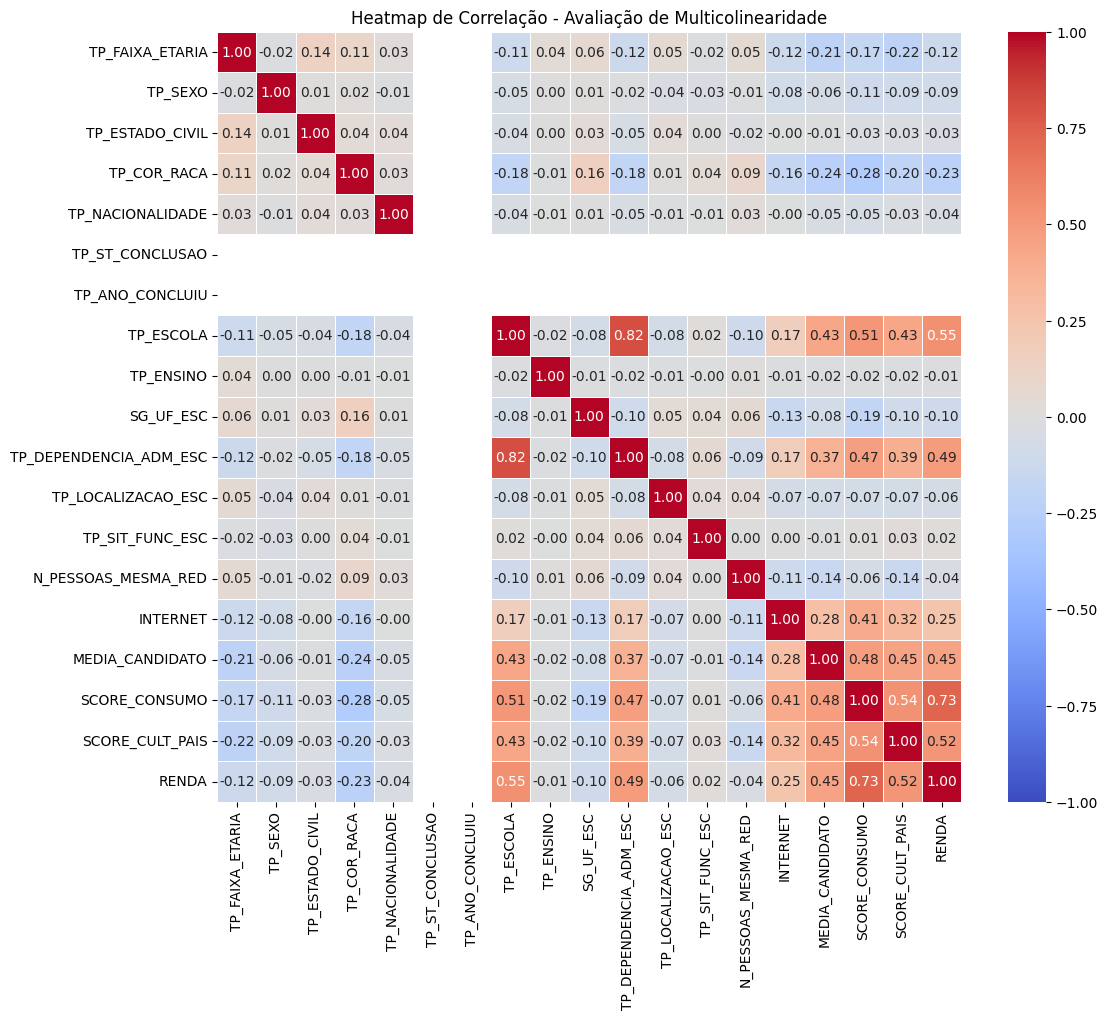

In [20]:
corr_matrix= sample.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Heatmap de Correlação - Avaliação de Multicolinearidade')
plt.show()

In [21]:
def gini(array):
    """Calcula o coeficiente de Gini de um array numérico."""


    if len(array) == 0:
        return 0

    array = array.astype(float)
    array += np.abs(np.min(array)) if np.min(array) < 0 else 0

    array = np.sort(array)
    index = np.arange(1, array.shape[0] + 1)
    n = array.shape[0]
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [22]:

def plot_lorenz_curve(dframe, coluna):

    v = dframe[coluna].dropna().sort_values().values
    lorenz = np.cumsum(v) / v.sum()
    lorenz = np.insert(lorenz, 0, 0)

    x_axis = np.linspace(0, 1, len(lorenz))

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=x_axis, y=lorenz, name='Curva de Lorenz',
                             fill='tozeroy', line=dict(color='blue')))

    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], name='Igualdade Perfeita',
                             line=dict(color='red', dash='dash')))


    fig.update_layout(title=f"Curva de Lorenz - Desigualdade em {coluna}<br>Índice de Gini: {gini(dframe[coluna]):.3f}",
                      xaxis_title="Porcentagem Acumulada da População",
                      yaxis_title="Porcentagem Acumulada do Valor",
                      width=700, height=600)
    fig.show()

In [23]:
plot_lorenz_curve(sample, 'SCORE_CONSUMO')
plot_lorenz_curve(sample, 'MEDIA_CANDIDATO')
